In [3]:
import math
import numpy as np


from sklearn.cross_validation import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

SEED = 199 

/extdrive1/anaconda3/envs/amlenv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
X = np.load('X.npy')
y = np.load('y.npy')
print(X[0:1,:])

print(X.shape, y.shape,sep='\n')
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=.33, random_state=SEED)



print(X_train.shape, X_test.shape,sep='\n')

[[-1.69864255  0.60587297  1.08623665 -1.35907589  0.09175171 -1.72917063
   0.32811388 -1.33958995  1.5332894   1.61508971  0.84722853 -1.62794317
  -1.52995417  1.12233683  1.2499034  -0.25931899  0.         -0.98360875
  -0.14856415  0.14856415  1.5279518  -0.99834025 -0.42239949 -0.22830453
  -1.02373279  1.02373279 -0.49957247  0.49957247 -0.97949492  0.97949492
   0.         -0.65835683 -0.81664618  1.53652841 -0.1517957  -0.12879773
  -0.12938451 -0.14993255 -0.14976212 -0.14856415 -0.13189904 -0.14526706
  -0.1514585  -0.12977432 -0.15463491 -0.14438795 -0.14314887 -0.13698402
  -0.14526706 -0.14027892 -0.14993255 -0.14118155 -0.14082114 -0.15313776
  -0.13399234 -0.13900615 -0.15010279 -0.13698402 -0.14082114 -0.14856415
  -0.1338033  -0.14596685 -0.1358693  -0.15078204 -0.13698402 -0.13937089
  -0.14064061 -0.15297059 -0.14735729 -0.13605567 -0.14009775 -0.14959152
  -0.13679882 -0.14189985 -0.14596685 -0.13304464 -0.14770303 -0.14561734
  -0.14243638 -0.13624181  6.71558628 

In [1]:
%%writefile model.py
class NeuralnetLayer(torch.nn.Sequential):
    
    def __init__(self,data_dim, output_dim):
        super(NeuralnetLayer, self).__init__()
       
        self.add_module('linear1', torch.nn.Linear(data_dim, 200))
        self.add_module('bn1', torch.nn.BatchNorm1d(200))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(200, 100))
        self.add_module('bn2', torch.nn.BatchNorm1d(100))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(100, 50))
        self.add_module('bn3', torch.nn.BatchNorm1d(50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50,output_dim))


Writing model.py


In [239]:
class GaussianProcessLayer(AbstractVariationalGP):
    def __init__(self, num_dim, grid_bounds, grid_size):
        variational_distribution = CholeskyVariationalDistribution(
                                                 num_inducing_points=grid_size,
                                                 batch_size=num_dim
                                                )
       
        variational_strategy = AdditiveGridInterpolationVariationalStrategy(
                                                         self,
                                                         grid_size=grid_size,
                                                         grid_bounds=[grid_bounds],
                                                         num_dim=num_dim,
                                                         variational_distribution=variational_distribution
                                                        )
        super(GaussianProcessLayer,self).__init__(variational_strategy)
        '''self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )'''
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_dum_dims=num_dim)
        self.mean_module = gpytorch.means.ConstantMean()
        self.grid_bounds = grid_bounds

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [240]:
class DKLModel(gpytorch.Module):
    def __init__(self, nnet_layer, num_dim, 
                 grid_bounds,grid_size):
        super(DKLModel, self).__init__()
        self.nnet_layer = nnet_layer
        self.gp_layer = GaussianProcessLayer(num_dim=num_dim, 
                                             grid_bounds=grid_bounds,
                                             grid_size=grid_size)
        self.grid_bounds = grid_bounds

    def forward(self, x):
        features = self.nnet_layer(x)
        features = gpytorch.utils.grid.scale_to_bounds(features, self.grid_bounds[0], self.grid_bounds[1])
        #features = features.view(features.size(0),-1)
        res = self.gp_layer(features)
        return res

In [11]:
from trainer import SvDklTrainer

X_train,y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train)
print(X_train.shape)
batch_size = 512
dataset = utils.TensorDataset(X_train,y_train)
dataloader = utils.DataLoader(dataset, 
                              batch_size = batch_size,
                              shuffle = True)

IndentationError: unindent does not match any outer indentation level (trainer.py, line 69)

In [242]:
hyper_param = {nn_lr=1e-2,
               lh_lr=1e-3,
               epochs=100,
               grid_size=64,
               grid_bound=(-1,1),
               latent_dim=2,
               input_dim=X_train.size(1)
              }

64


[0. 0. 0. ... 1. 0. 0.]
[1. 0. 0. ... 1. 1. 1.]
AUC score:  0.51
Accuracy score:  0.17


In [216]:
import torch.optim as optim
class Net(nn.Module):
    
    def __init__(self,data_dim):
        super().__init__()
        self.fc1 = nn.Linear(data_dim, 400)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(400, 200)
        self.relu2 = nn.ReLU()
        self.dout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(200, 50)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(50, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.dout2(h2)
        h3 = self.fc3(a3)
        a3 = self.relu3(h3)
        fc4 =self.fc4(a3)
        y = self.out_act(fc4)
        return y
    
net = Net(X_train.shape[1])
opt = optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [217]:
def train_epoch(model, opt, criterion, dataloader, batch_size=50):
    model.train()
    losses = []
    for i, (x,y) in enumerate(dataloader):

        opt.zero_grad()
        # (1) Forward
        y_hat = net(x)
        # (2) Compute diff
        loss = criterion(y_hat, y)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

/extdrive1/anaconda3/envs/amlenv/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/extdrive1/anaconda3/envs/amlenv/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([401])) that is different to the input size (torch.Size([401, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


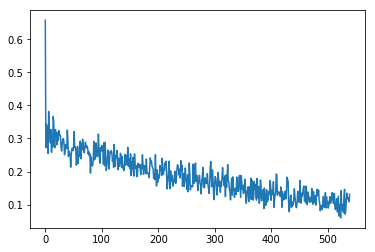

In [218]:
import matplotlib.pyplot as plt
%matplotlib inline

e_losses = []
num_epochs = 20
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion,dataloader)
plt.plot(e_losses)

In [219]:
test_dataset = utils.TensorDataset(torch.FloatTensor(X_test),
                                   torch.FloatTensor(y_test))
test_dataloader = utils.DataLoader(test_dataset,batch_size=24)

y_pred_lst = []
y_truth_lst = []

with torch.no_grad():
    for i, (X, y) in enumerate(test_dataloader):
        
        output = net(X)
        
        y_pred = output.ge(0.5).float().cpu().numpy()
        y_pred_lst.append(y_pred)
        y_truth_lst.append(y.numpy())
        
    truth = np.concatenate(y_truth_lst)
    pred =  np.concatenate(y_pred_lst)
   
    auc = roc_auc_score(truth,pred)
    accuracy = accuracy_score(truth,pred)   
    
print("AUC score: ",round(auc,2))
print("Accuracy score: ",round(accuracy,2))

AUC score:  0.68
Accuracy score:  0.91
